In [1]:
import pandas as pd
import statistics
import numpy as np
import seaborn as sns
import tabulate
import matplotlib.pyplot as plt
from fastdtw import fastdtw  #Package pour calculer les distances entre 2 séries de tailles différentes

# Exploratory Data Analysis

## Loading and creating different dataframes

In [2]:
df=pd.read_json("match_1.json")
df2=pd.read_json("match_2.json")

full_df = pd.concat([df,df2])
full_df.reset_index(drop=True, inplace=True)

In [3]:
df.head(5)

,label,norm
0,walk,"[23.177037336396975, 23.361525285249378, 21.53..."
1,walk,"[20.998214383911275, 19.182798059840767, 18.27..."
2,walk,"[21.95259682019565, 20.62720484424047, 22.5554..."
3,walk,"[19.39209748358647, 19.30460665293087, 18.9787..."
4,rest,"[22.069263037713093, 19.672270483203395, 19.88..."


In [4]:
df['longueur'] = df['norm'].apply(lambda x: len(x))
df2['longueur'] = df2['norm'].apply(lambda x: len(x))
full_df['longueur'] = full_df['norm'].apply(lambda x: len(x))


#df['min'] = df['norm'].apply(lambda x: min(x))
#df['max'] = df['norm'].apply(lambda x: max(x))
#df['mean'] = df['norm'].apply(lambda x: statistics.mean(x))

#df2['min'] = df2['norm'].apply(lambda x: min(x))
#df2['max'] = df2['norm'].apply(lambda x: max(x))
#df2['mean'] = df2['norm'].apply(lambda x: statistics.mean(x))

full_df['min'] = full_df['norm'].apply(lambda x: min(x))
full_df['max'] = full_df['norm'].apply(lambda x: max(x))
full_df['mean'] = full_df['norm'].apply(lambda x: statistics.mean(x))

## Statistical Analysis

In [5]:
print(full_df.groupby('label')[['longueur','min','max','mean']].agg(['mean','min','max','sum','count']))


             longueur                              min                        \
                 mean min  max    sum count       mean        min        max   
label                                                                          
cross       52.500000  30   72    210     4  12.619630   4.101426  24.805225   
dribble     39.256410   3  100   3062    78  14.323510   3.979596  40.056210   
no action  134.000000  76  192    268     2   4.709407   4.233360   5.185455   
pass        42.687500   3  102   1366    32  16.705475   6.310896  65.472226   
rest       115.771429  18  723   4052    35  15.396717   5.072868  19.019414   
run         37.657609   1   94  20787   552  14.956424   1.674630  48.603239   
shot        33.777778   4   66    608    18  23.971054  10.425894  42.575182   
tackle      46.225806  20  118   1433    31  13.173210   3.561442  34.400466   
walk        55.326437   8  179  24067   435  12.308385   1.999615  22.441406   

                                     ma

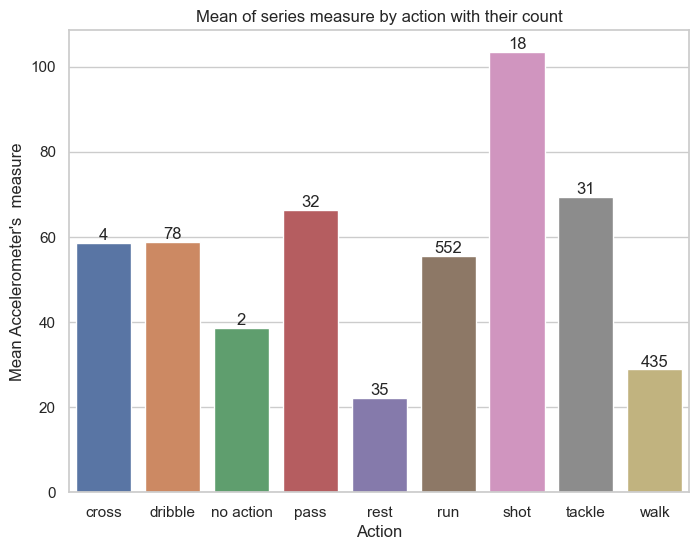

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=full_df.groupby('label')['mean'].mean().index, y=full_df.groupby('label')['mean'].mean().values)

plt.xlabel('Action')
plt.ylabel('Mean Accelerometer\'s  measure')
plt.title('Mean of series measure by action with their count')

ax.bar_label(ax.containers[0], labels=full_df.groupby('label').agg(['count'])['norm']['count'])
    
plt.show()

We clearly see a difference in the accelerometer measure for the shots, rest, and walk compared to the other actions. We can also point out that the actions "cross", "no action" and "shot" do not appear frequently in the dataset. 

In [7]:
def calculate_statistics(series):
    mean_value = series.mean()
    median_value = series.median()
    std_deviation = series.std()
    percentile_95 = series.quantile(0.95)
    max_val = series.max()
    min_val = series.min()

    
    return mean_value, median_value, std_deviation, percentile_95, max_val, min_val

In [8]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross']:
    combin_lab = full_df[full_df['label']==label]
    lab_df = combin_lab['norm'].explode()

    mean, median, std, percentile_95, max_val, min_val = calculate_statistics(lab_df)

    print("STATISTICS FOR THE ACTION : ", label)
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std)
    print("95th Percentile:", percentile_95)
    print("Max :", max_val)
    print("Min :", min_val)
    print("--------------------")

STATISTICS FOR THE ACTION :  walk
Mean: 28.320189265213653
Median: 23.780701942807543
Standard Deviation: 15.13108615609897
95th Percentile: 52.84842639752487
Max : 549.5750681191864
Min : 1.999615484483988
--------------------
STATISTICS FOR THE ACTION :  rest
Mean: 21.741159926079078
Median: 20.769884284937664
Standard Deviation: 4.603694214771405
95th Percentile: 28.615552580136672
Max : 101.9427471459145
Min : 5.072868360471503
--------------------
STATISTICS FOR THE ACTION :  run
Mean: 53.2052595508952
Median: 43.03405727070558
Standard Deviation: 46.913965269558034
95th Percentile: 120.79841204367143
Max : 759.8614139522053
Min : 1.674629720598801
--------------------
STATISTICS FOR THE ACTION :  tackle
Mean: 65.58008355251444
Median: 44.771698256303644
Standard Deviation: 75.07931691290578
95th Percentile: 182.92057566536664
Max : 739.2771908152429
Min : 3.561441685329417
--------------------
STATISTICS FOR THE ACTION :  dribble
Mean: 57.36999217117668
Median: 45.354258156642395

To get a better understanding of the actions and their appearence in a game it seems interesting to have a look from a power perspective. We can see in the data that some actions are highly consumming energy (shot, pass, tackle) while some others are there to help the player get it's energy back (rest/walk). I want to understand the frequency of those action during a game

In [9]:
Full_data_1 = df['norm'].explode().reset_index(drop=True)
Full_data_2 = df2['norm'].explode().reset_index(drop=True)

In [10]:
Valeur_effort = 29
Nombre_action_seconde = 50

Puissance_seconde_1 = [
    sum(Full_data_1[i:i + Nombre_action_seconde])
    for i in range(0, len(Full_data_1) - Nombre_action_seconde  + 1, Nombre_action_seconde )
]

Puissance_seconde_2 = [
    sum(Full_data_2[i:i + Nombre_action_seconde])
    for i in range(0, len(Full_data_2) - Nombre_action_seconde  + 1, Nombre_action_seconde )
]

We take 29 as the value for the accelerometer where the player is resting (95% of the data for rest is below this value). Meaning that every action with a power above 29*50 per second (because we have 50 measures per seconds) will result in a decrease of energy for the player while everything below will help him recover

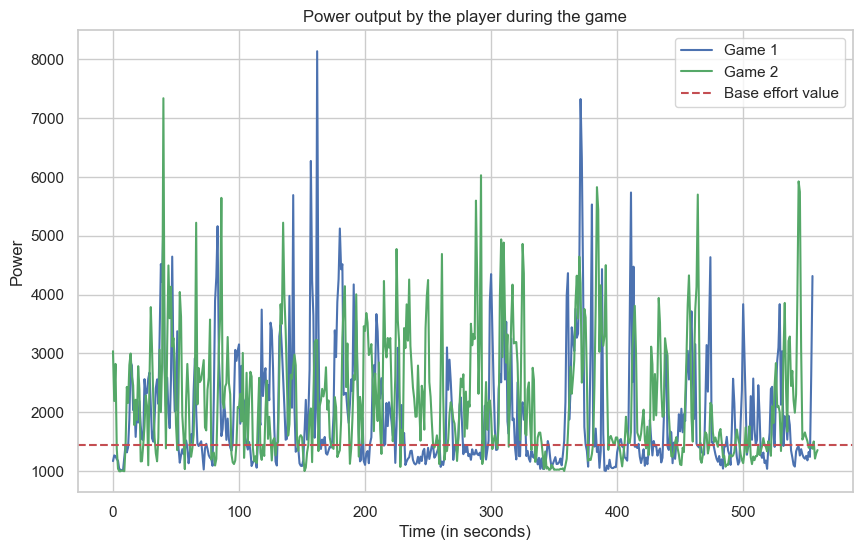

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(Puissance_seconde_1)), Puissance_seconde_1, label = 'Game 1')
plt.plot(range(len(Puissance_seconde_2)), Puissance_seconde_2, color='g', label = 'Game 2')
plt.axhline(y=Valeur_effort*Nombre_action_seconde, color='r', linestyle='--', label='Base effort value')

plt.xlabel('Time (in seconds)')
plt.ylabel('Power')
plt.title('Power output by the player during the game')
plt.legend()
plt.show()

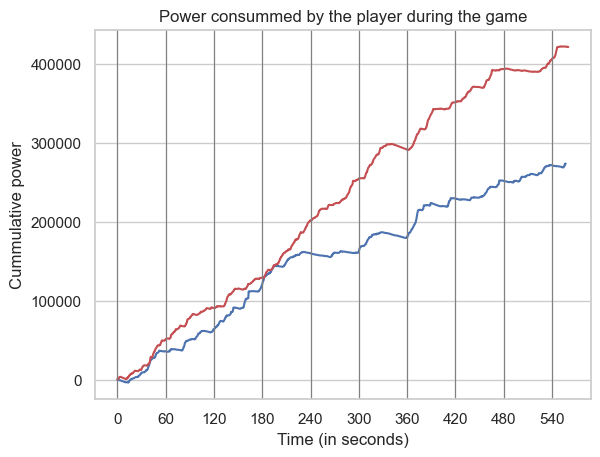

In [16]:
data_subtracted_1 = Full_data_1 - 29
data_subtracted_2 = Full_data_2 - 29

# Calculer le cumulatif de la série soustraite
cumulative_data_1 = data_subtracted_1.cumsum()

cumulative_data_2 = data_subtracted_2.cumsum()


# Tracer le cumulatif
plt.plot(cumulative_data_1, label = 'Game 1')
plt.plot(cumulative_data_2, color ='r', label = 'Game 2')
plt.xlabel('Time (in seconds)')
plt.ylabel('Cummulative power')
plt.title('Power consummed by the player during the game')

plt.xticks(range(0, len(cumulative_data_2), 60*50), [str(i) for i in range(0, int(len(cumulative_data_2)/50), 60)])



for x in range(0, len(cumulative_data_2), 60*50):
    plt.axvline(x=x, color='grey', linewidth = 0.8)



plt.show()

We can see that the power output is really different between the 2 games. This can be used a factor to play with the intensity when we will generate our own games

In [17]:
Puissance_recup = 0
Puissance_effort = 0
Puissance_minute_1 = []
t=0
for i in range(len(Puissance_seconde_1)):
    if Puissance_seconde_1[i] <= Nombre_action_seconde*Valeur_effort :
        Puissance_recup = Puissance_recup + ((Nombre_action_seconde*Valeur_effort) - Puissance_seconde_1[i])
    else :
        Puissance_effort = Puissance_effort + (Puissance_seconde_1[i] - (Nombre_action_seconde*Valeur_effort))
    if i%60 == 0 :
        t=t+1
        Puissance_max_1 = Puissance_effort - Puissance_recup
        if t==1 :
            Puissance_minute_1.append(Puissance_max_1)
        else :
            Puissance_minute_1.append(Puissance_max_1-Puissance_minute_1[t-2])

Puissance_max_1 = Puissance_effort - Puissance_recup
print("Maximal power output for Game 1 : ", Puissance_max_1)
print("Power output for every minute of the Game 1 : ", Puissance_minute_1)

Puissance_recup = 0
Puissance_effort = 0
Puissance_minute_2 = []
t=0
for i in range(len(Puissance_seconde_2)):
    if Puissance_seconde_2[i] <= Nombre_action_seconde*Valeur_effort :
        Puissance_recup = Puissance_recup + ((Nombre_action_seconde*Valeur_effort) - Puissance_seconde_2[i])
    else :
        Puissance_effort = Puissance_effort + (Puissance_seconde_2[i] - (Nombre_action_seconde*Valeur_effort))
    if i%60 == 0 :
        t=t+1
        Puissance_max_2 = Puissance_effort - Puissance_recup
        if t==1 :
            Puissance_minute_2.append(Puissance_max_2)
        else :
            Puissance_minute_2.append(Puissance_max_2-Puissance_minute_2[t-2])

Puissance_max_2 = Puissance_effort - Puissance_recup
print("Maximal power output for Game 2 : ", Puissance_max_2)
print("Power output for every minute of the Game 2 : ", Puissance_minute_2)

Maximal power output for Game 1 :  273140.7989372657
Power output for every minute of the Game 1 :  [-279.1517687712271, 35899.49182594746, 29392.50934455418, 95332.40005180906, 64477.867158031964, 101820.04100417171, 81143.77211028954, 148046.46385159582, 103629.4197737262, 167715.40453332494]
Maximal power output for Game 2 :  421588.41067481926
Power output for every minute of the Game 2 :  [1587.7100031862965, 50707.03661821973, 40134.92416767271, 88740.20219746833, 113636.55622099822, 141649.6934828016, 149470.16873733653, 202563.70518616983, 191095.64504734566, 216174.6615310175]


## Not done yet

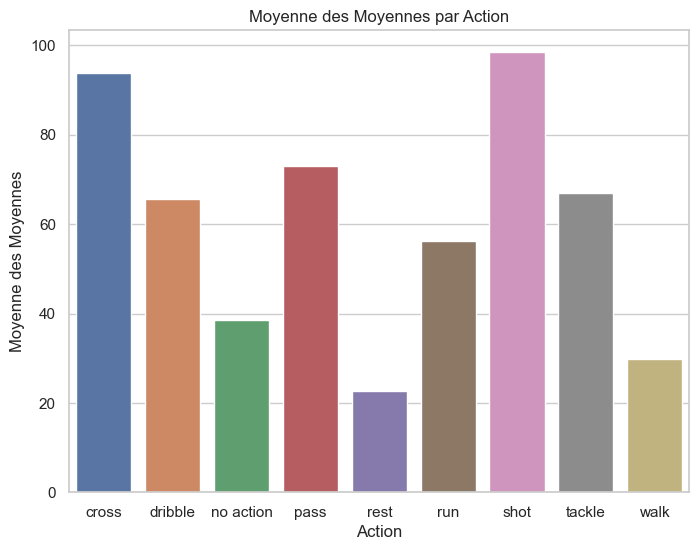

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=df2.groupby('label')['mean'].mean().index, y=df2.groupby('label')['mean'].mean().values)
plt.xlabel('Action')
plt.ylabel('Moyenne des Moyennes')
plt.title('Moyenne des Moyennes par Action')
plt.show()

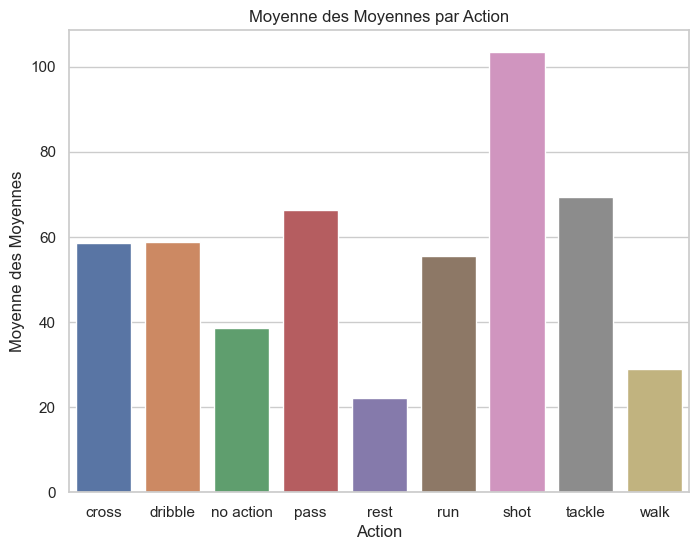

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=full_df.groupby('label')['mean'].mean().index, y=full_df.groupby('label')['mean'].mean().values)
plt.xlabel('Action')
plt.ylabel('Moyenne des Moyennes')
plt.title('Moyenne des Moyennes par Action')
plt.show()

In [3]:
combin_rest = [df[df['label']=='rest'].reset_index(drop=True),df2[df2['label']=='rest'].reset_index(drop=True)]
df_rest = pd.concat(combin_rest)

In [22]:
combin_lab = [df[df['label']=='walk'].reset_index(drop=True),df2[df2['label']=='walk'].reset_index(drop=True)]

In [25]:
for label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross']:
    combin_lab = [df[df['label']==label].reset_index(drop=True),df2[df2['label']==label].reset_index(drop=True)]
    df_lab = pd.concat(combin_lab)
    lab_df = df_lab['norm'].explode()

    mean, median, std, percentile_95, max_val, min_val = calculate_statistics(lab_df)

    print("STATISTICS FOR THE ACTION : ", label)
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std)
    print("95th Percentile:", percentile_95)
    print("Max :", max_val)
    print("Min :", min_val)

STATISTICS FOR THE ACTION :  walk
Mean: 28.320189265213653
Median: 23.780701942807543
Standard Deviation: 15.13108615609897
95th Percentile: 52.84842639752487
Max : 549.5750681191864
Min : 1.999615484483988
STATISTICS FOR THE ACTION :  rest
Mean: 21.741159926079078
Median: 20.769884284937664
Standard Deviation: 4.603694214771405
95th Percentile: 28.615552580136672
Max : 101.9427471459145
Min : 5.072868360471503
STATISTICS FOR THE ACTION :  run
Mean: 53.2052595508952
Median: 43.03405727070558
Standard Deviation: 46.913965269558034
95th Percentile: 120.79841204367143
Max : 759.8614139522053
Min : 1.674629720598801
STATISTICS FOR THE ACTION :  tackle
Mean: 65.58008355251444
Median: 44.771698256303644
Standard Deviation: 75.07931691290578
95th Percentile: 182.92057566536664
Max : 739.2771908152429
Min : 3.561441685329417
STATISTICS FOR THE ACTION :  dribble
Mean: 57.36999217117668
Median: 45.354258156642395
Standard Deviation: 49.42118635814242
95th Percentile: 137.33490801330177
Max : 719

273140.7989372657
[-279.1517687712271, 35899.49182594746, 29392.50934455418, 95332.40005180906, 64477.867158031964, 101820.04100417171, 81143.77211028954, 148046.46385159582, 103629.4197737262, 167715.40453332494]


421588.41067481926
[1587.7100031862965, 50707.03661821973, 40134.92416767271, 88740.20219746833, 113636.55622099822, 141649.6934828016, 149470.16873733653, 202563.70518616983, 191095.64504734566, 216174.6615310175]


In [61]:
Puissance_minute

[-279.1517687712271,
 35620.34005717623,
 65292.00117050164,
 124724.90939636323,
 159810.26720984103,
 166297.90816220368,
 182963.81311446126,
 229190.23596188537,
 251675.88362532202,
 271344.82430705114]

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(Bricolage)), Bricolage)
plt.axhline(y=28*50, color='r', linestyle='--', label='Mean Proportion')

plt.xlabel('Time')
plt.ylabel('Puissance')
plt.title('Puissance par seconde')
plt.xticks(range(len(Bricolage)), range(50 - 1, len(Full_data)))
plt.show()

KeyboardInterrupt: 

In [18]:
# Define the size of the moving window
window_size = 50 #1 seconde


    # Define the label you want to analyze
for target_label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross'] :



    # Calculate the proportion of the target label within each window
    proportions = [
        sum(1 for label in sampled_labels[i:i + window_size] if label == target_label) / window_size
        for i in range(len(sampled_labels) - window_size + 1)
    ]

    mean_proportion = sum(proportions) / len(proportions)


    # Plot the proportions over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(proportions)), proportions)
    plt.axhline(y=mean_proportion, color='r', linestyle='--', label='Mean Proportion')

    plt.xlabel('Time')
    plt.ylabel('Proportion of ' + target_label)
    plt.title('Proportion of ' + target_label + ' Over Time')
    plt.xticks(range(len(proportions)), range(window_size - 1, len(sampled_labels)))
    plt.show()

NameError: name 'sampled_labels' is not defined

In [131]:
# Select two actions for DTW comparison
action1 = 'walk'
action2 = 'rest'

dtw_distances = []

subset_action1 = df[df['label'] == action1]['norm']
#len(subset_action1)
for i in range(15):
    dtw_row = []
    for j in range(15):
        dtw_distance, _ = fastdtw(subset_action1.iloc[i], subset_action1.iloc[j])
        dtw_row.append(dtw_distance)
    dtw_distances.append(dtw_row)

# Convert the DTW distances to a DataFrame
dtw_distance_df = pd.DataFrame(dtw_distances, index=range(1, 15+1),
                                columns=range(1, 15+1))

print(dtw_distance_df)


            1           2           3           4           5           6   \
1     0.000000  165.141459  140.721108  317.457134  377.904423  331.612902   
2   165.141459    0.000000  326.713116  363.144490  375.729618  346.627840   
3   140.721108  326.713116    0.000000  155.147477  466.697324  369.323323   
4   317.457134  363.144490  155.147477    0.000000  412.208803  473.876030   
5   377.904423  375.729618  466.697324  412.208803    0.000000  455.244206   
6   331.612902  346.627840  369.323323  473.876030  455.244206    0.000000   
7   249.515526  302.448774  308.805062  390.321880  374.337702  298.938317   
8   691.341715  611.074419  734.913194  838.989325  690.656669  598.074001   
9   313.754060  347.105328  324.771295  548.015391  380.439646  497.466344   
10  366.624000  378.688404  613.523389  589.789224  304.518689  463.216778   
11  243.628586  269.246794  244.827305  276.430752  276.005308  332.681939   
12  473.169696  442.067258  529.834354  483.498128  678.402071  

In [134]:
print(  dtw_distance_df/(dtw_distance_df.max().max()))

          1         2         3         4         5         6         7   \
1   0.000000  0.167023  0.142325  0.321074  0.382211  0.335392  0.252359   
2   0.167023  0.000000  0.330436  0.367282  0.380011  0.350578  0.305895   
3   0.142325  0.330436  0.000000  0.156915  0.472015  0.373532  0.312324   
4   0.321074  0.367282  0.156915  0.000000  0.416906  0.479276  0.394769   
5   0.382211  0.380011  0.472015  0.416906  0.000000  0.460432  0.378603   
6   0.335392  0.350578  0.373532  0.479276  0.460432  0.000000  0.302345   
7   0.252359  0.305895  0.312324  0.394769  0.378603  0.302345  0.000000   
8   0.699219  0.618037  0.743287  0.848549  0.698526  0.604889  0.573323   
9   0.317329  0.351060  0.328472  0.554260  0.384775  0.503135  0.388935   
10  0.370802  0.383003  0.620514  0.596510  0.307989  0.468495  0.428687   
11  0.246405  0.272315  0.247617  0.279581  0.279150  0.336473  0.200855   
12  0.478561  0.447104  0.535872  0.489007  0.686132  0.335321  0.401102   
13  0.274843

In [5]:
# Select two actions for DTW comparison
action1 = 'walk'
action2 = 'rest'

dtw_distance = pd.DataFrame()

for i in range(len(df[df['label'] == action1]['norm'])):
    for j in range(len(df[df['label'] == action1]['norm'])):
        # Compute DTW distance between two actions
        subset_action1 = df[df['label'] == action1]['norm'].iloc[0]
        subset_action2 = df[df['label'] == action1]['norm'].iloc[0]

        # Compute DTW distance between two actions
        dtw_distance[i,j] = fastdtw(subset_action1, subset_action2)



NameError: name 'subset_action1' is not defined

In [19]:

# Calculate the maximum length of series in the "norm" column
max_length = df['norm'].apply(len).max()

# Expand the "norm" column into separate columns
expanded_norm = df['norm'].apply(pd.Series)

# Rename the expanded columns
expanded_norm.columns = [f'Value_{i + 1}' for i in range(max_length)]

# Concatenate the expanded columns with the "label" column
result_df = pd.concat([df['label'], expanded_norm], axis=1)

print(result_df)

      label    Value_1    Value_2    Value_3    Value_4    Value_5  \
0      walk  23.177037  23.361525  21.535253  23.400315  23.007525   
1      walk  20.998214  19.182798  18.272491  19.690260  20.830143   
2      walk  21.952597  20.627205  22.555408  20.016869  20.381994   
3      walk  19.392097  19.304607  18.978771  22.324970  21.747552   
4      rest  22.069263  19.672270  19.882150  21.101266  20.078084   
..      ...        ...        ...        ...        ...        ...   
569    walk  21.245737  21.938836  21.245737  21.088881  21.245737   
570    walk  20.272348  21.820303  21.211776  20.638558  21.522611   
571     run  90.213060  72.127128  63.564388  70.379536  60.210597   
572  tackle  44.795103  27.264069  88.616417  60.052678  85.664416   
573     run  21.329404  27.394755  43.789041  14.375416  25.502124   

        Value_6    Value_7     Value_8    Value_9  ...  Value_218  Value_219  \
0     22.927317  23.143662   22.916891  22.265134  ...        NaN        NaN   

In [20]:
from ydata_profiling import ProfileReport

profile = ProfileReport(result_df, tsmode=True)
profile.to_file('profile_report_resutldf.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: sample size is too short to use selected regression component

In [23]:
sum(df2['longueur'])/50

560.12

In [7]:
data=df[df['label']=='cross']['norm'].iloc[2]

In [36]:
len(data)

1

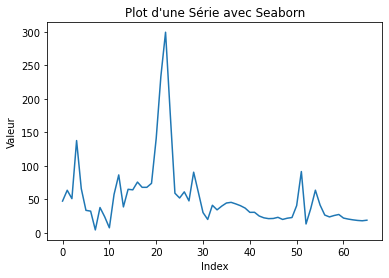

In [8]:
# Créer un plot de ligne avec Seaborn
sns.lineplot(x=range(len(data)), y=data)

# Ajouter des étiquettes et un titre
plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Plot d\'une Série avec Seaborn')

# Afficher le plot
plt.show()

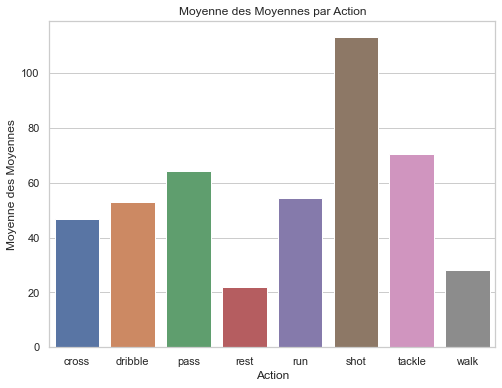

In [16]:
labels_1 = df.label
labels_2 = df2.label

In [17]:
label_data_1 = {}
label_data_2 = {}
# Count occurrences and followed counts
for i in range(len(labels_1) - 1):
    current_label = labels_1[i]
    next_label = labels_1[i + 1]
    
    if current_label not in label_data_1:
        label_data_1[current_label] = {'total': 0, 'followed': {}}
    
    label_data_1[current_label]['total'] += 1
    
    if next_label not in label_data_1[current_label]['followed']:
        label_data_1[current_label]['followed'][next_label] = 0
    
    label_data_1[current_label]['followed'][next_label] += 1


# Count occurrences and followed counts
for i in range(len(labels_2) - 1):
    current_label = labels_2[i]
    next_label = labels_2[i + 1]
    
    if current_label not in label_data_2:
        label_data_2[current_label] = {'total': 0, 'followed': {}}
    
    label_data_2[current_label]['total'] += 1
    
    if next_label not in label_data_2[current_label]['followed']:
        label_data_2[current_label]['followed'][next_label] = 0
    
    label_data_2[current_label]['followed'][next_label] += 1


# Convert the nested dictionary into a DataFrame
data_for_df_1 = {}
data_for_df_2 = {}

for label, data in label_data_1.items():
    percentages = {followed_label: (followed_count / data['total']) if data['total'] > 0 else 0
                for followed_label, followed_count in data['followed'].items()}
    data_for_df_1[label] = percentages

df_per_1 = pd.DataFrame(data_for_df_1).fillna(0).T

for label, data in label_data_2.items():
    percentages = {followed_label: (followed_count / data['total']) if data['total'] > 0 else 0
                for followed_label, followed_count in data['followed'].items()}
    data_for_df_2[label] = percentages

df_per_2 = pd.DataFrame(data_for_df_2).fillna(0).T


# Convert transposed DataFrame to tabular format
tabulated_output_1 = tabulate.tabulate(df_per_1, headers='keys', tablefmt='pretty')
tabulated_output_2 = tabulate.tabulate(df_per_2, headers='keys', tablefmt='pretty')
# Print the tabulated output
print(tabulated_output_1)
print(tabulated_output_2)

+---------+----------------------+----------------------+---------------------+----------------------+---------------------+----------------------+----------------------+----------------------+
|         |         walk         |         rest         |         run         |        tackle        |       dribble       |         pass         |         shot         |        cross         |
+---------+----------------------+----------------------+---------------------+----------------------+---------------------+----------------------+----------------------+----------------------+
|  walk   |  0.7510204081632653  | 0.07346938775510205  | 0.13877551020408163 | 0.00816326530612245  | 0.02040816326530612 | 0.00816326530612245  |         0.0          |         0.0          |
|  rest   |         0.76         |         0.0          |         0.2         |         0.0          |         0.0         |         0.04         |         0.0          |         0.0          |
|   run   | 0.1105769230769230

In [24]:
df_per_1.iloc[0]

walk       0.751020
rest       0.073469
run        0.138776
tackle     0.008163
dribble    0.020408
pass       0.008163
shot       0.000000
cross      0.000000
Name: walk, dtype: float64

In [28]:
# Number of steps in the MCMC simulation
num_steps = len(df)

# Initial state (replace with the initial label index)
current_state = 0

# Create an array to store the samples
samples = []

# Perform the MCMC simulation
for _ in range(num_steps):
    # Propose a new state based on the transition probabilities
    proposed_state = np.random.choice(len(df_per_1), p=df_per_1.iloc[current_state])
    
    # Move to the proposed state
    current_state = proposed_state
    
    # Store the current state as a sample
    samples.append(current_state)

# Convert label indices to actual labels
label_mapping = ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross']
sampled_labels = [label_mapping[state] for state in samples]

# Print the sampled labels
print("Sampled labels:", sampled_labels)

Sampled labels: ['pass', 'rest', 'run', 'run', 'walk', 'walk', 'run', 'dribble', 'dribble', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'walk', 'walk', 'walk', 'pass', 'walk', 'rest', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'tackle', 'run', 'run', 'dribble', 'dribble', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'walk', 'walk', 'walk', 'rest', 'walk', 'walk', 'walk', 'rest', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'dribble', 'pass', 'cross', 'shot', 'walk', 'walk', 'walk', 'run', 'run', 'run', 'tackle', 'tackle', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'walk', 'run', 'tackle', 'tackle', 'run', '

In [36]:
series_lengths = df[df['label']=='rest'].applymap(len)

In [37]:
series_lengths['norm']

4      181
86      68
93      36
134     40
137     70
158     74
182    142
236     74
243     69
259     36
265     22
280     86
297     88
317     36
329     26
360     73
374    204
407     70
418    116
422    227
424    210
449     38
507     72
519     98
538     82
Name: norm, dtype: int64

In [42]:
series_labeled = df[df['label']==target_label] 

In [46]:
len(series_labeled['norm'])

3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


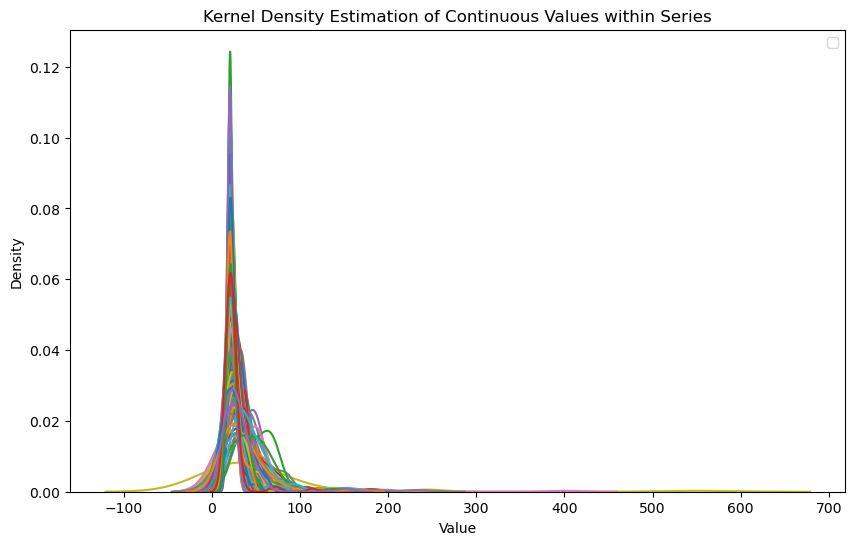

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


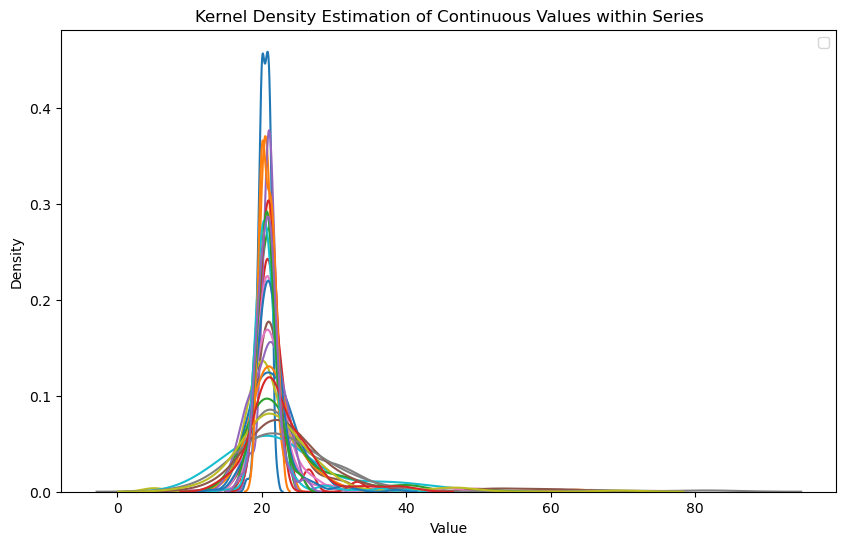

c:\Users\jerem\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\jerem\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


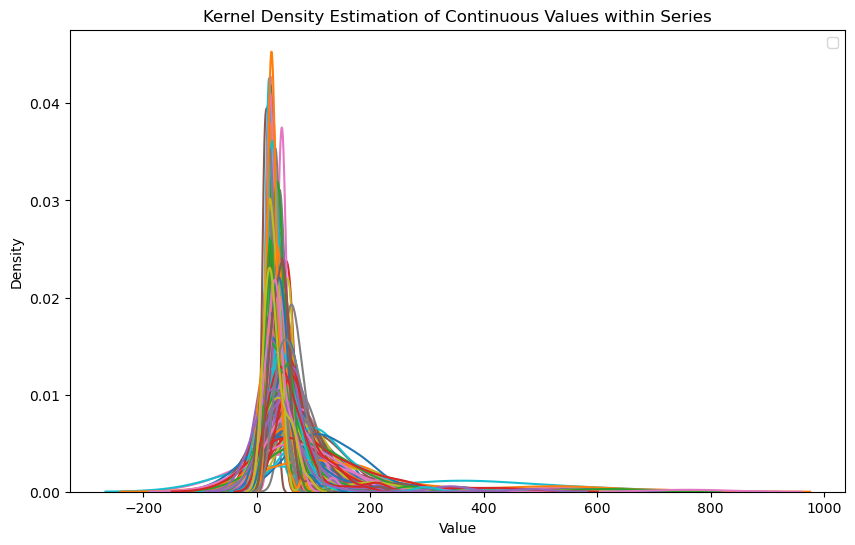

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


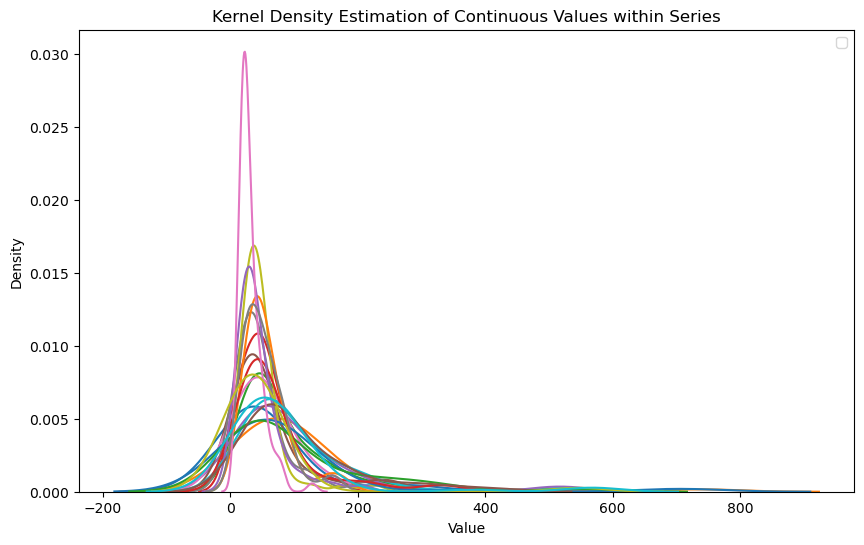

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


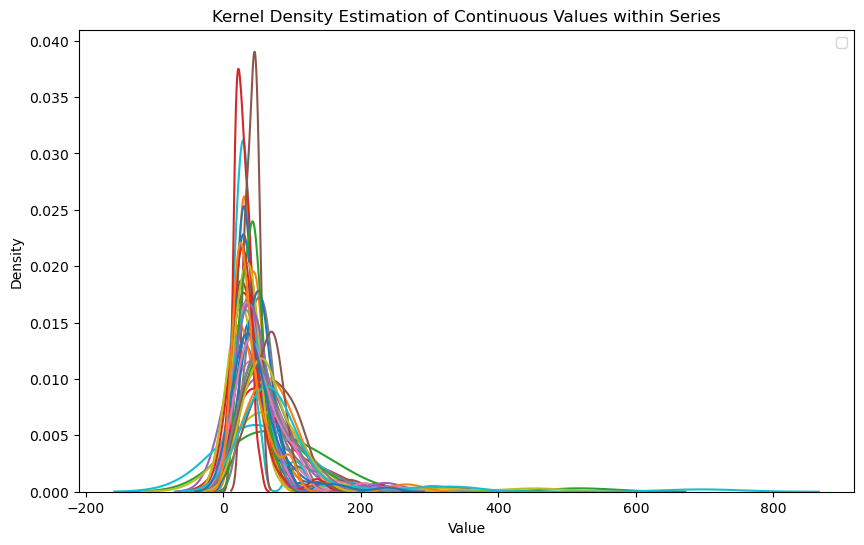

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


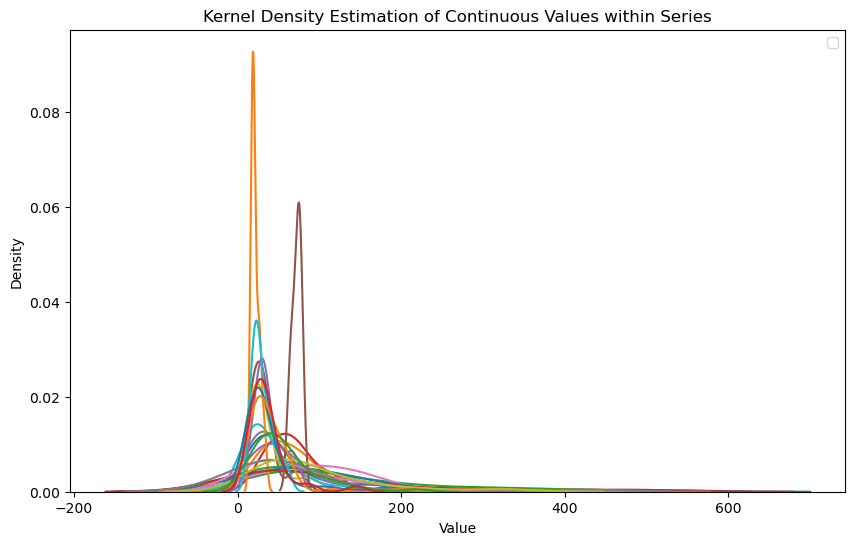

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


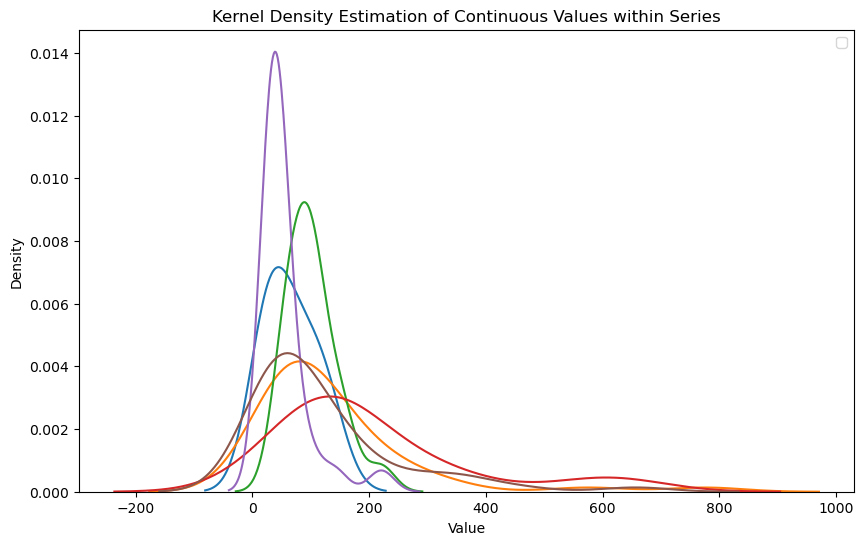

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


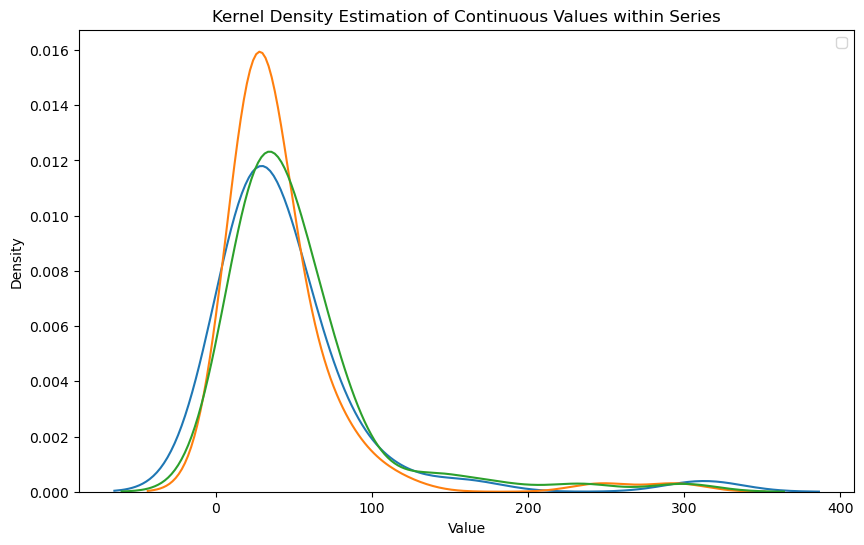

In [49]:
for target_label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross'] :

    # Calculate the lengths of each series
    series_labeled = df[df['label']==target_label]    # Plot the distribution of continuous values within each series using KDE
    plt.figure(figsize=(10, 6))
    for i in range(len(series_labeled['norm'])):
        sns.kdeplot(series_labeled['norm'].iloc[i])

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Continuous Values within Series')

    plt.show()

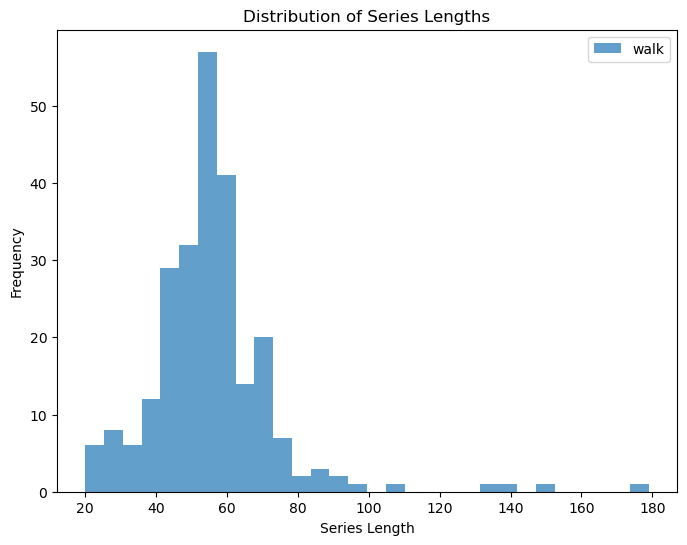

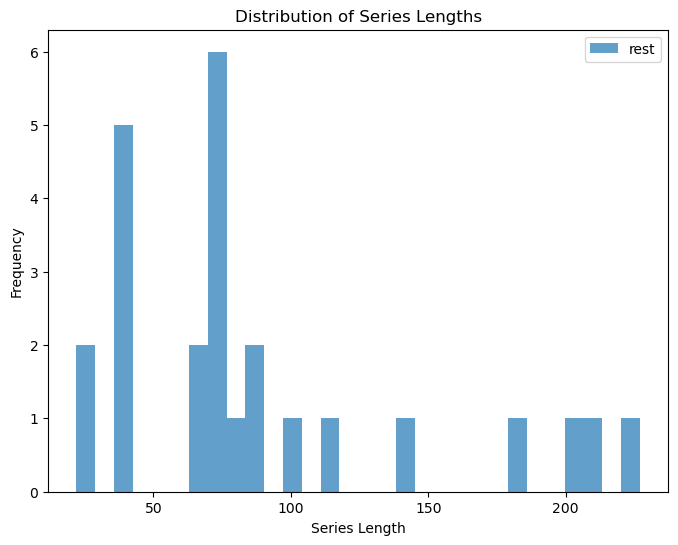

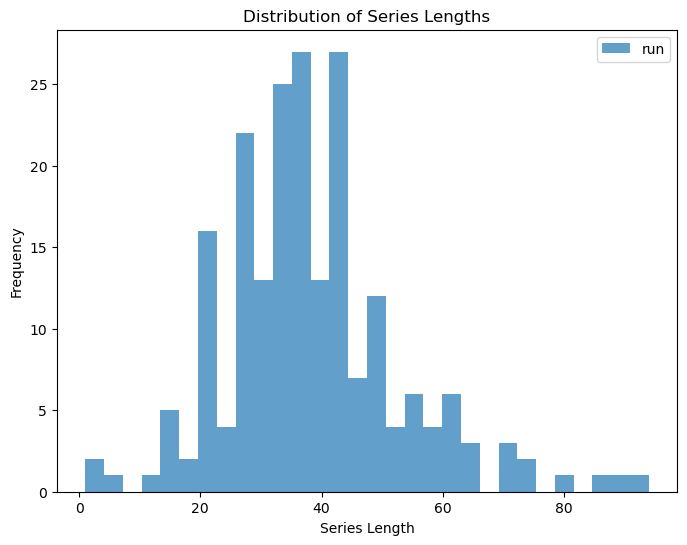

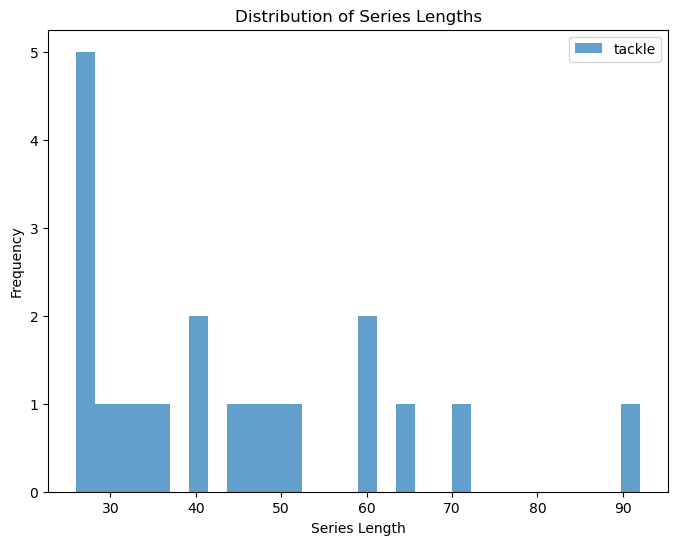

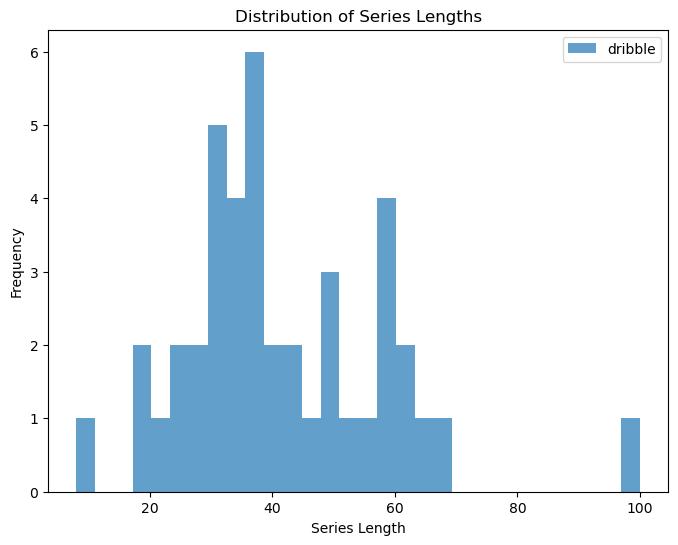

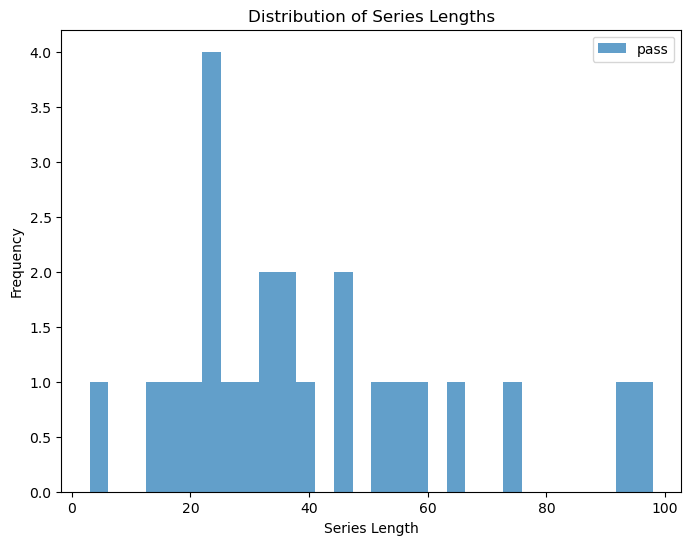

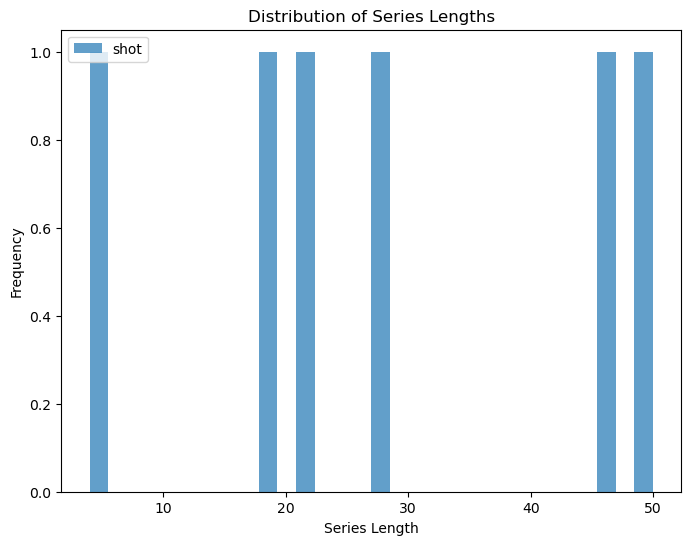

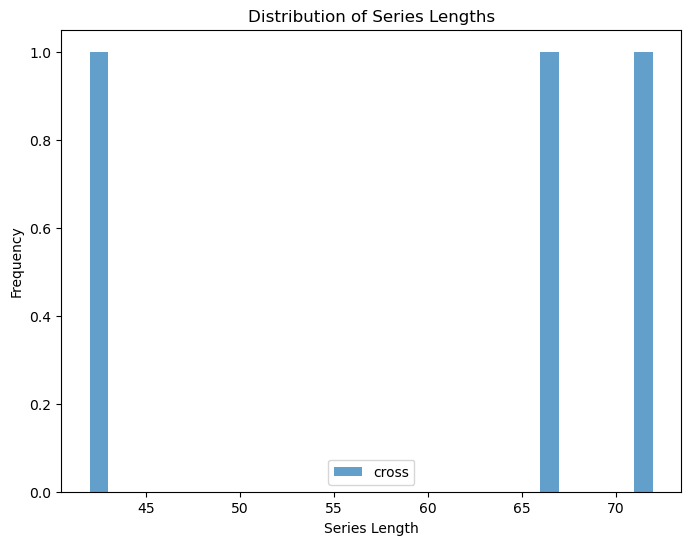

In [41]:
for target_label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross'] :

    # Calculate the lengths of each series
    series_lengths = df[df['label']==target_label].applymap(len)

    # Plot the distribution of series lengths
    plt.figure(figsize=(8, 6))
    plt.hist(series_lengths['norm'].values, bins=30, alpha=0.7, label=target_label)
    plt.xlabel('Series Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Series Lengths')
    plt.legend()
    plt.show()

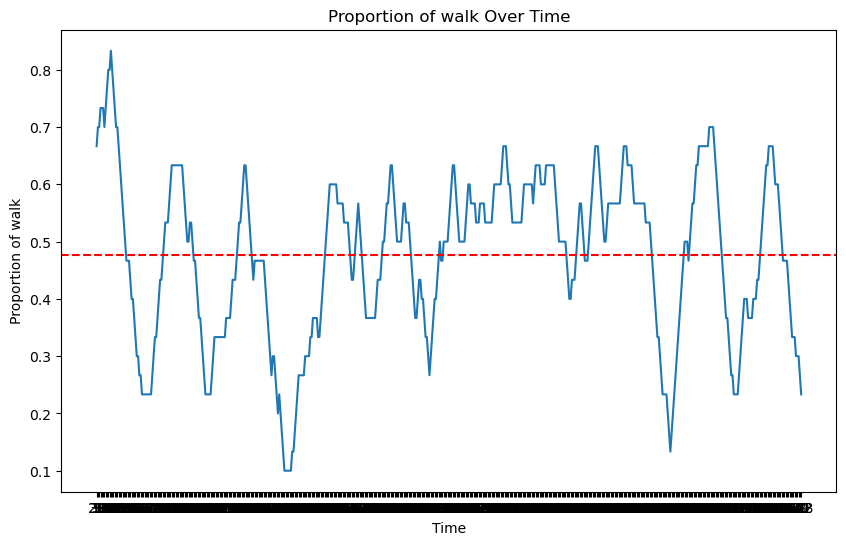

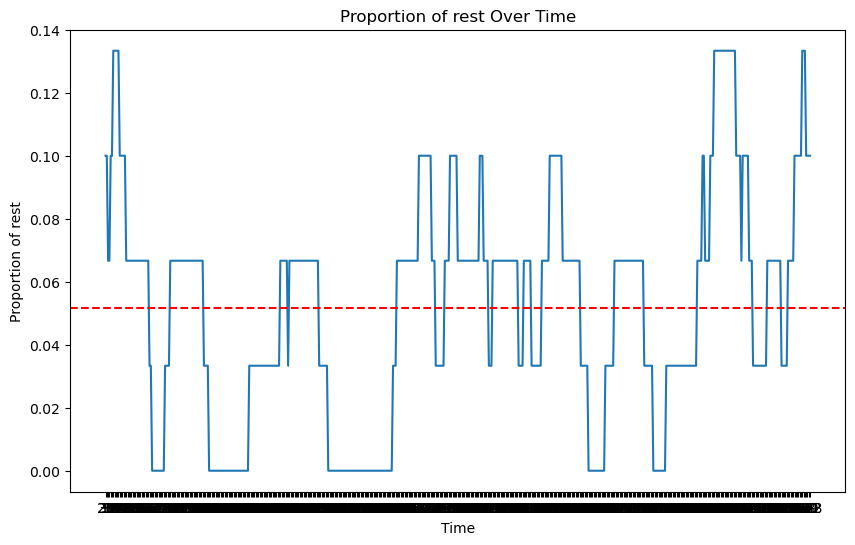

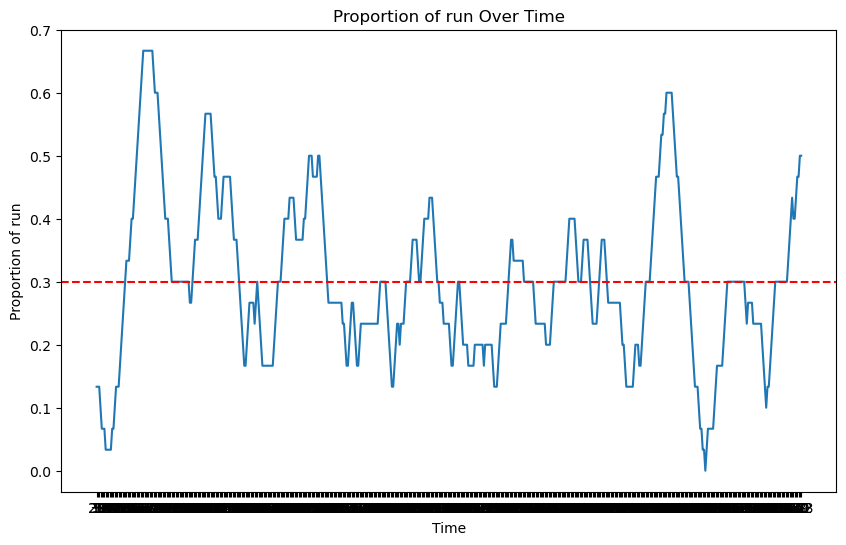

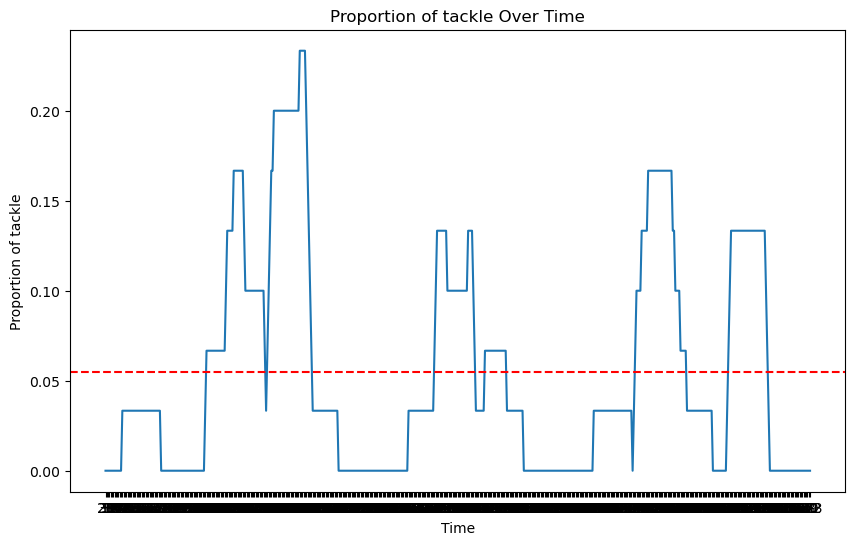

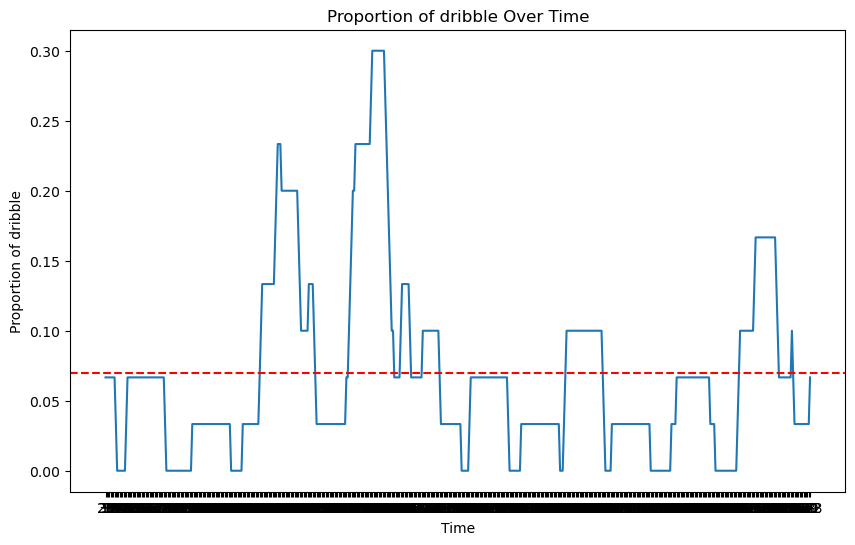

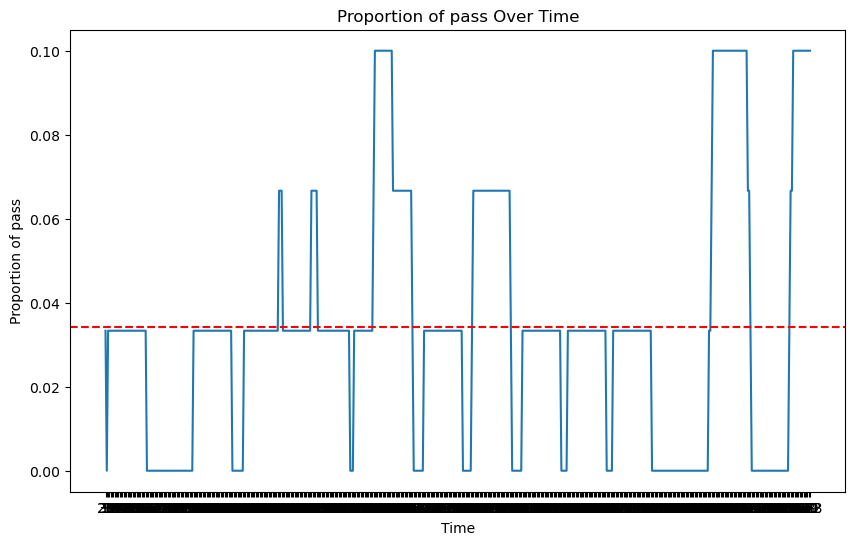

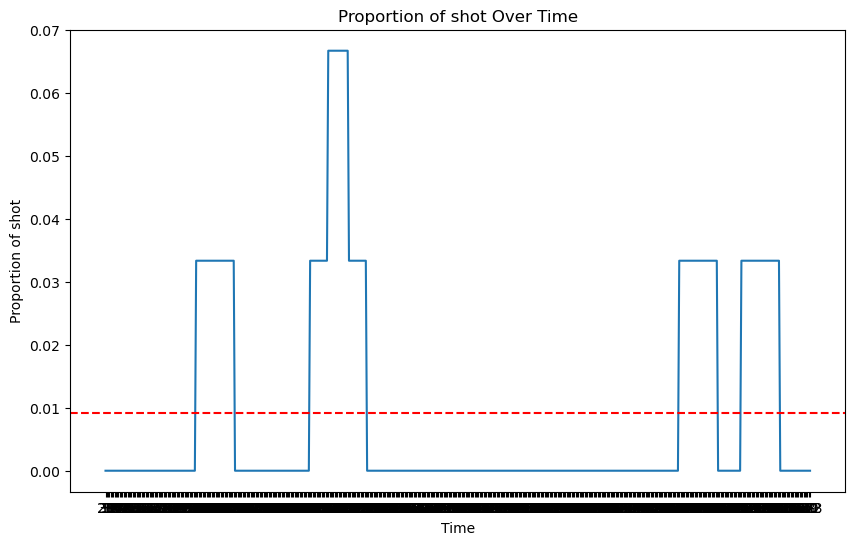

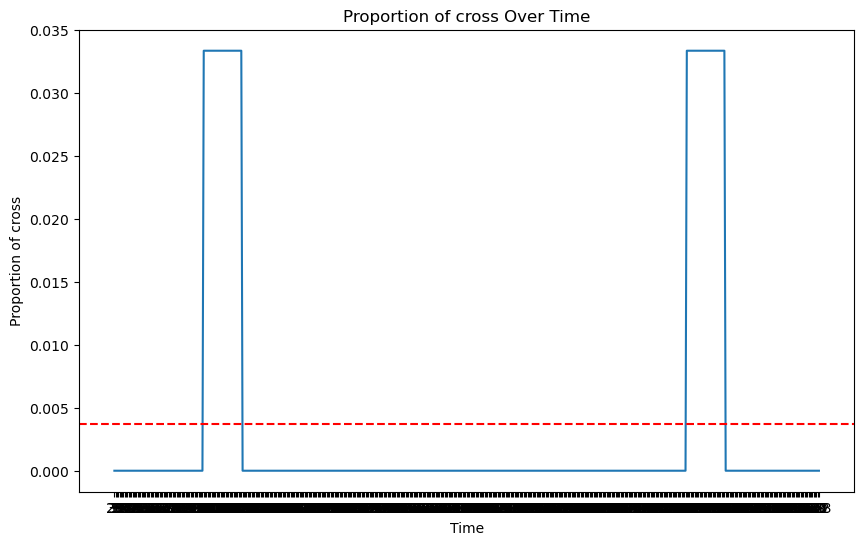

In [31]:
# Define the size of the moving window
window_size = 30


    # Define the label you want to analyze
for target_label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross'] :



    # Calculate the proportion of the target label within each window
    proportions = [
        sum(1 for label in sampled_labels[i:i + window_size] if label == target_label) / window_size
        for i in range(len(sampled_labels) - window_size + 1)
    ]

    mean_proportion = sum(proportions) / len(proportions)


    # Plot the proportions over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(proportions)), proportions)
    plt.axhline(y=mean_proportion, color='r', linestyle='--', label='Mean Proportion')

    plt.xlabel('Time')
    plt.ylabel('Proportion of ' + target_label)
    plt.title('Proportion of ' + target_label + ' Over Time')
    plt.xticks(range(len(proportions)), range(window_size - 1, len(sampled_labels)))
    plt.show()

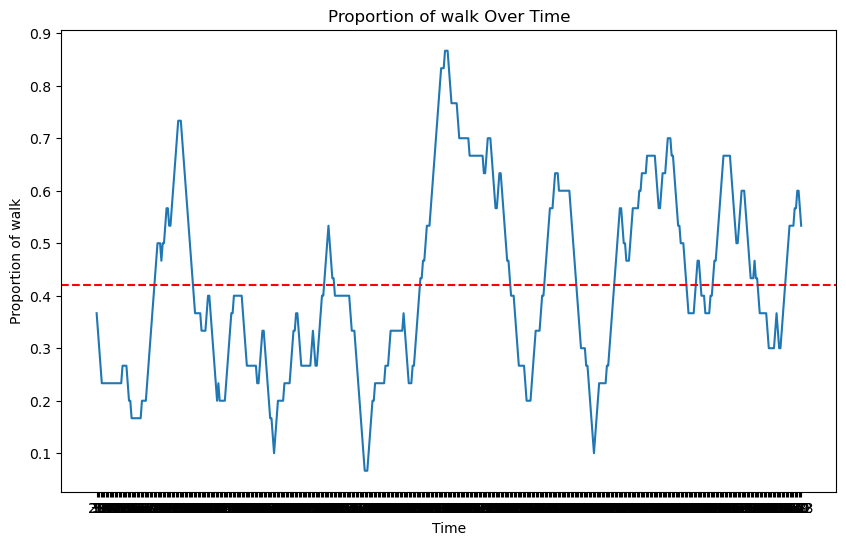

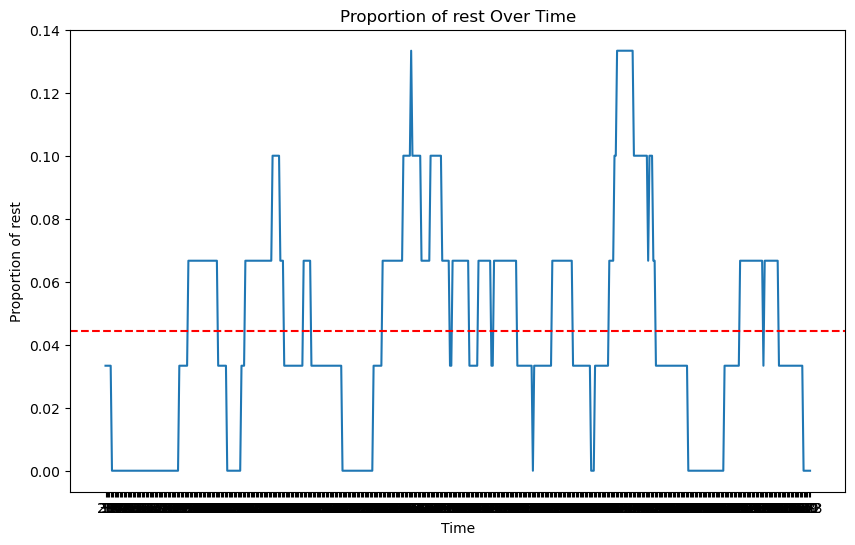

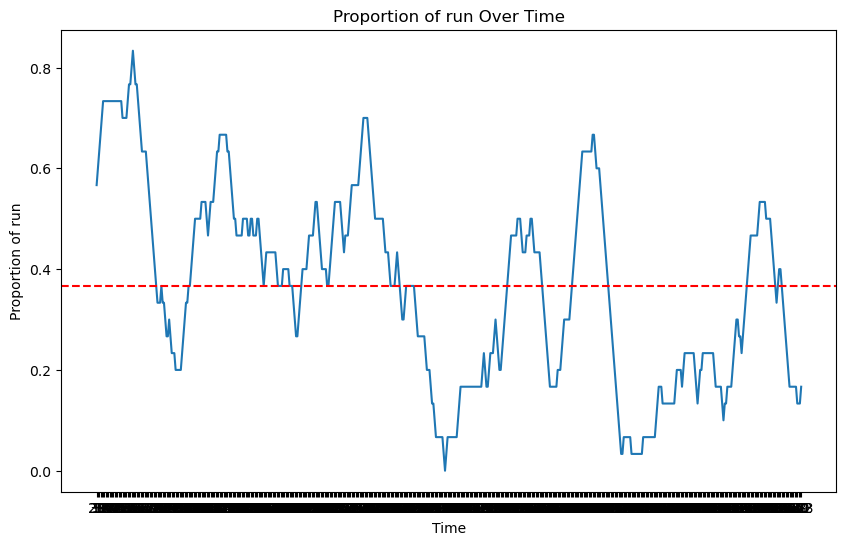

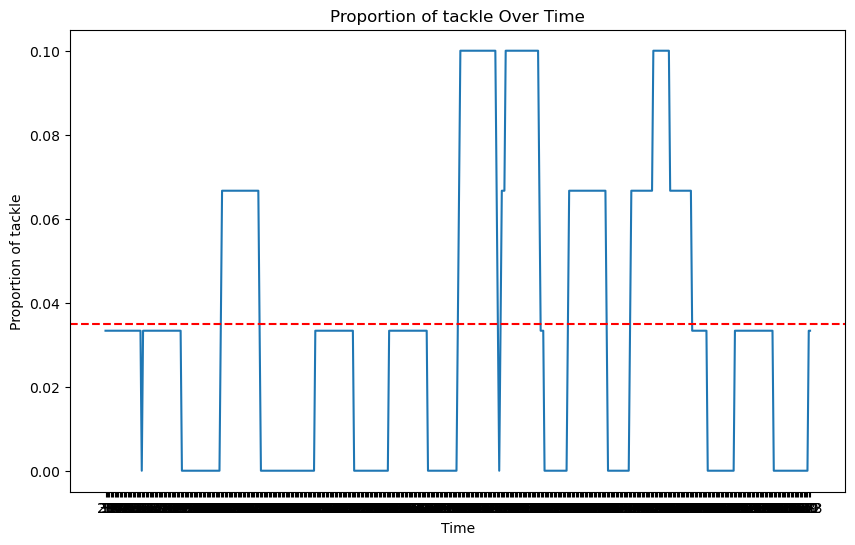

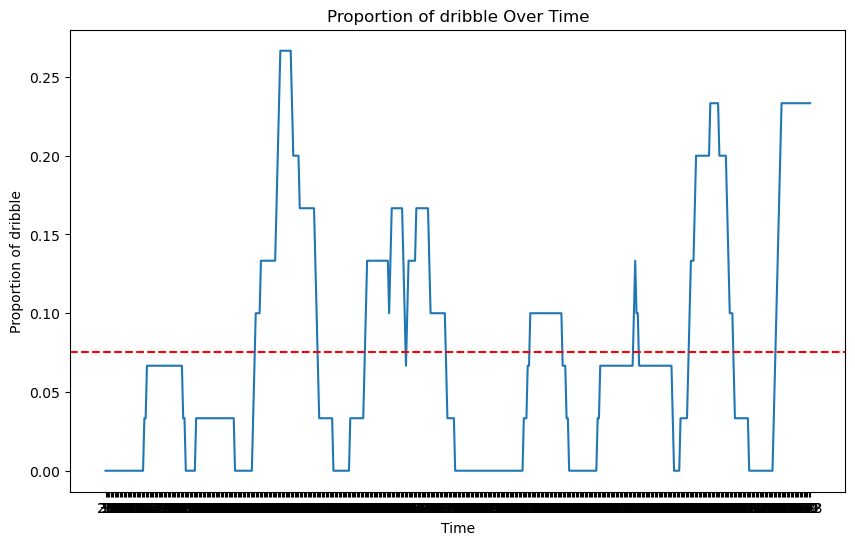

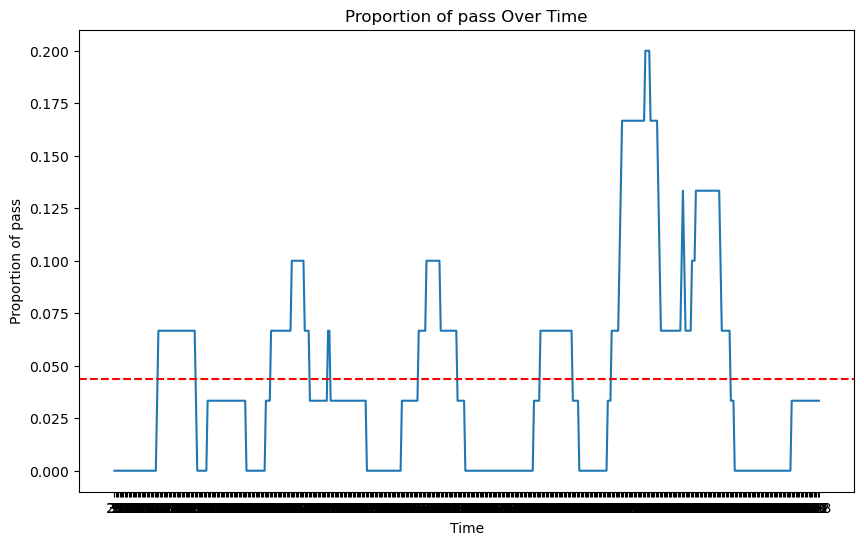

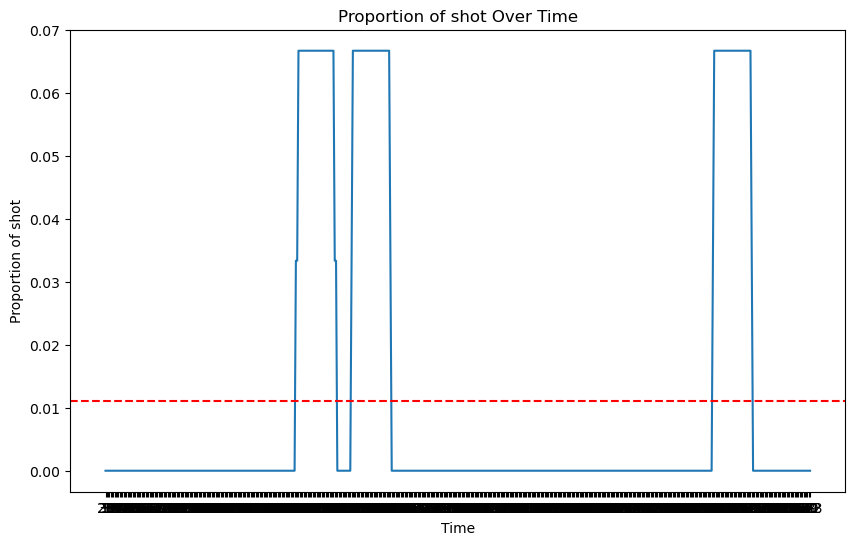

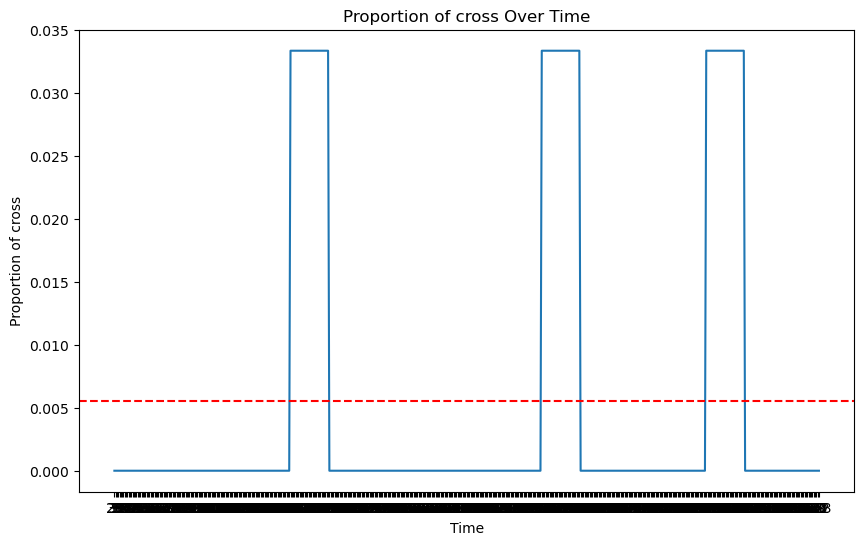

In [32]:
# Define the size of the moving window
window_size = 30


    # Define the label you want to analyze
for target_label in ['walk', 'rest', 'run', 'tackle', 'dribble', 'pass', 'shot', 'cross'] :

    # Calculate the proportion of the target label within each window
    proportions = [
        sum(1 for label in labels_1[i:i + window_size] if label == target_label) / window_size
        for i in range(len(labels_1) - window_size + 1)
    ]

    mean_proportion = sum(proportions) / len(proportions)


    # Plot the proportions over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(proportions)), proportions)
    plt.axhline(y=mean_proportion, color='r', linestyle='--', label='Mean Proportion')

    plt.xlabel('Time')
    plt.ylabel('Proportion of ' + target_label)
    plt.title('Proportion of ' + target_label + ' Over Time')
    plt.xticks(range(len(proportions)), range(window_size - 1, len(labels_1)))
    plt.show()

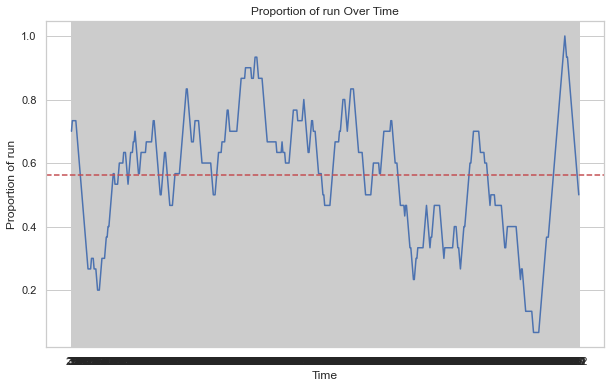

In [41]:
# Define the label you want to analyze
target_label = 'run'

# Define the size of the moving window
window_size = 30

# Calculate the proportion of the target label within each window
proportions = [
    sum(1 for label in labels_2[i:i + window_size] if label == target_label) / window_size
    for i in range(len(labels_2) - window_size + 1)
]
# Calculate the mean of the proportions
mean_proportion = sum(proportions) / len(proportions)

# Plot the proportions over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(proportions)), proportions)
plt.axhline(y=mean_proportion, color='r', linestyle='--', label='Mean Proportion')
plt.xlabel('Time')
plt.ylabel('Proportion of ' + target_label)
plt.title('Proportion of ' + target_label + ' Over Time')
plt.xticks(range(len(proportions)), range(window_size - 1, len(labels_2)))
plt.show()

In [11]:
# Calculate the percentages for each label
label_percentages = {}
for i in range(len(labels) - 1):
    current_label = labels[i]
    next_label = labels[i + 1]
    
    if current_label not in label_percentages:
        label_percentages[current_label] = {'total': 0, 'followed': 0}
    
    label_percentages[current_label]['total'] += 1
    if next_label != current_label:
        label_percentages[current_label]['followed'] += 1

# Calculate and display the percentages
for label, data in label_percentages.items():
    percentage = (data['followed'] / data['total']) * 100 if data['total'] > 0 else 0
    print(f"The percentage of labels following '{label}' is: {percentage:.2f}%")

The percentage of labels following 'walk' is: 24.90%
The percentage of labels following 'rest' is: 100.00%
The percentage of labels following 'run' is: 28.37%
The percentage of labels following 'tackle' is: 70.00%
The percentage of labels following 'dribble' is: 54.76%
The percentage of labels following 'pass' is: 79.17%
The percentage of labels following 'cross' is: 100.00%
The percentage of labels following 'shot' is: 66.67%


In [68]:
df['Mean_Length'] = df['norm'].apply(lambda x: len(x))
mean_length_per_action = df.groupby('label')['Mean_Length'].mean()

# Normaliser les longueurs des séries moyennes
normalized_lengths = (mean_length_per_action - mean_length_per_action.min()) / (mean_length_per_action.max() - mean_length_per_action.min())


In [71]:
df['Normalized_Size'] = df.groupby('label')['norm'].transform(lambda x: len(x)) / df['norm'].apply(len)


In [72]:
df['Normalized_Size']

0      3.402778
1      4.537037
2      3.602941
3      3.266667
4      0.138122
         ...   
569    2.882353
570    5.104167
571    6.531250
572    0.312500
573    5.805556
Name: Normalized_Size, Length: 574, dtype: float64

In [117]:
dataframe = df[df['label']=='run']

In [113]:
dataframe

,label,norm,longueur
176,shot,"[35.47820704552003, 23.462783850464124, 78.264...",4
178,shot,"[55.233501150175805, 61.24897403673542, 95.992...",46
219,shot,"[53.453573991725854, 42.0082421034424, 220.946...",21
220,shot,"[143.34440047494698, 252.83178857364425, 137.0...",19
498,shot,"[25.29218224776564, 31.196913964106116, 30.911...",27
499,shot,"[42.84227455862855, 64.50948327737989, 57.1259...",50


In [115]:
len(success)

50

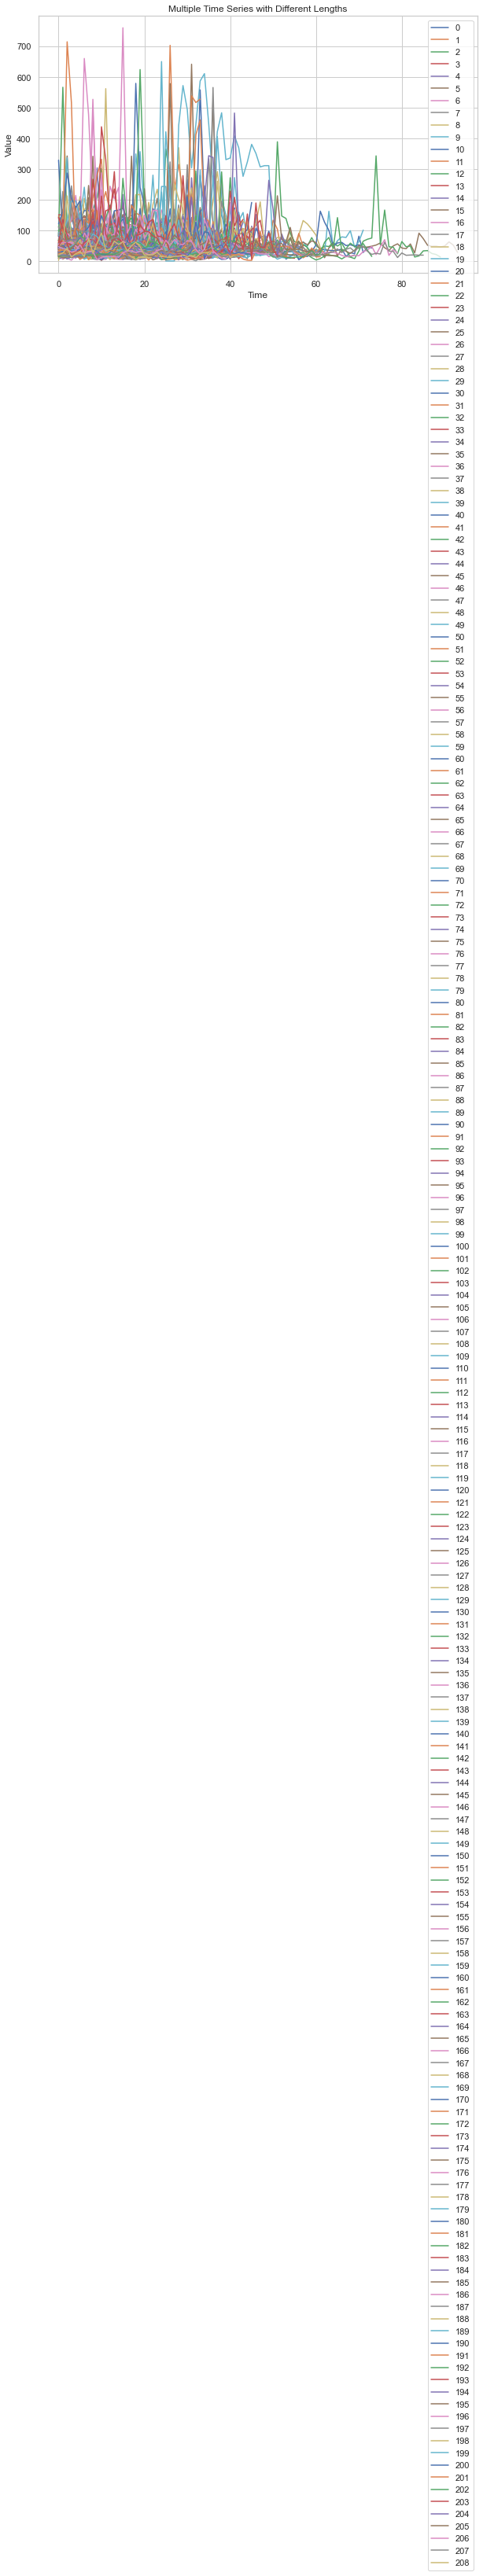

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a DataFrame from the data
success = pd.DataFrame()
for i in range(len(dataframe['norm'])):
    success = pd.concat([success, pd.DataFrame(dataframe['norm'].iloc[i])], axis=1)
    
new_column_names = list(range(len(success.columns)))
success.columns = new_column_names
    
    # Plotting
plt.figure(figsize=(10, 6))

for column in success.columns:
    plt.plot(success.index[:len(success[column])], success[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multiple Time Series with Different Lengths')
plt.legend()
plt.show()

In [21]:
p_six_tails_in_a_row = 0.47**10
p_no_six_tails_in_a_row = (1 - p_six_tails_in_a_row)**(500 - 10 + 1)
p_at_least_one_six_tails_in_a_row = 1 - p_no_six_tails_in_a_row

percentage = p_at_least_one_six_tails_in_a_row * 100

print("Probability:", p_at_least_one_six_tails_in_a_row)
print("Percentage:", percentage)

Probability: 0.2276594388315356
Percentage: 22.76594388315356
